In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

# topic_modelling_df = pd.read_csv('./main_df_output/topic_modelling_df.csv')
topic_modelling_df_without_token = pd.read_csv('./main_df_output/topic_modelling_df_without_token.csv')
sentiment_analysis_df = pd.read_csv("./main_df_output/sentiment_analysis_df.csv")
sentiment_analysis_df_with_price = pd.read_csv('./main_df_output/sentiment_analysis_df_with_price.csv')

In [10]:
# List all yahoo tickers
yahoo_ticker_list = [
    # Motor/Personal
    'ADM.L','DLG.L','SBRE.L','SAGA.L','AGS.BR',
    # Global Commercial
    'ALV.DE','CS.PA','ZURN.SW','G.MI',
    # London Market 
    'BEZ.L','HSX.L','LRE.L',
    # LN Equity 
    'LLOY.L',
    # US - Specialty/P&C/Reinsurance
    'AIG','AXS','TRV','ACGL','RNR','RE','MKL','HIG','ARGO','BRK-B','CB',
    # European (Re)Insurers
    'SCR.PA','MUV2.DE','SREN.SW','HNR1.DE',
    # Japanese & Pacific
    '8766.T','8630.T','8725.T','QBE.AX',
    # Run-off
    'ESGR','FFH.TO','RQIH.L',
    # Life Groups & Retail Life
    'PRU.L','MNG.L','LGEN.L','AV.L','PHNX.L','QLT.L','JUST.L','STJ.L','AGN.AS','DSY.JO','SLM.JO',
    # Other insurers
    'STB.OL','CNP.PA','GJF.OL','PST.MI','NN.AS','TOP.CO','BALN.SW',
    'SAMPO.HE','MAP.MC','TRYG.CO','0RHS.IL','HELN.SW','IFC.TO'
]

# Match it with company names from BoE
Insurer_Names_df = pd.read_excel('./input/Insurer_Names_for_possible_NLP_analysis.xlsx')  
Insurer_Names = Insurer_Names_df.drop(['Unnamed: 0', 'Unnamed: 4'], axis=1)
Insurer_Names = Insurer_Names.drop([0])
Insurer_Names.rename(columns={"Unnamed: 1": "Company", "Unnamed: 2": "bb ticker", "Unnamed: 3":"Group"}, inplace = True)
Insurer_Names['yahoo ticker'] = yahoo_ticker_list
Insurer_Names
# Exported as CSV to manually matched with the extracted file names (column 'company_name' in model_df)
Insurer_Names[['Company']].to_csv('./main_df_output/company_name_match.csv', index = False)

In [11]:
company_name_match = pd.read_csv('./main_df_output/company_name_match.csv')
company_name_match.rename(columns={"Company": "company_name"}, inplace = True)
# company_name_match

In [12]:
Groups = {
        "ADMIRAL GROUP" : "Motor/Personal", "DIRECT LINE INSU" : "Motor/Personal", 
        "SABRE INSUR" : "Motor/Personal", "SAGA PLC" : "Motor/Personal",
        "AGEAS" : "Motor/Personal",

        "ALLIANZ SE-REG" : "Global Commercial", "AXA" : "Global Commercial", 
        "ZURICH INSURANCE" : "Global Commercial", "GENERALI ASSIC" : "Global Commercial",

        "BEAZLEY PLC" : "London Market", "HISCOX LTD" : "London Market", 
        "LANCASHIRE HOLDI" : "London Market",
        
        "Society of Lloyd’s" : "LN Equity",

        "AMERICAN INTERNA" : "US - Specialty/P&C/Reinsurance", "AXIS CAPITAL" : "US - Specialty/P&C/Reinsurance",
        "TRAVELERS COS IN" : "US - Specialty/P&C/Reinsurance", "ARCH CAPITAL GRP" : "US - Specialty/P&C/Reinsurance",
        "RENAISSANCERE" : "US - Specialty/P&C/Reinsurance", "EVEREST RE GROUP" : "US - Specialty/P&C/Reinsurance",
        "MARKEL CORP" : "US - Specialty/P&C/Reinsurance", "HARTFORD FINL SV" : "US - Specialty/P&C/Reinsurance",
        "ARGO GROUP INTER" : "US - Specialty/P&C/Reinsurance", "BERKSHIRE HATH-B" : "US - Specialty/P&C/Reinsurance",
        "CHUBB LTD" : "US - Specialty/P&C/Reinsurance",

        "SCOR SE" : "European (Re)Insurers", "MUENCHENER RUE-R" : "European (Re)Insurers", 
        "SWISS RE AG" : "European (Re)Insurers", "HANNOVER RUECK S" : "European (Re)Insurers",

        "TOKIO MARINE HD" : "Japanese & Pacific", "SOMPO HOLDINGS I" : "Japanese & Pacific",
        "MS&AD INSURANCE" : "Japanese & Pacific", "QBE INSURANCE" : "Japanese & Pacific",

        "ENSTAR GROUP LTD" : "Run-off", "FAIRFAX FINL HLD" : "Run-off", "RANDALL & QUILTE" : "Run-off",

        "PRUDENTIAL PLC" : "Life Groups & Retail Life", "M&G PLC" : "Life Groups & Retail Life",
        "LEGAL & GEN GRP" : "Life Groups & Retail Life", "AVIVA PLC" : "Life Groups & Retail Life",
        "PHOENIX GROUP HO" : "Life Groups & Retail Life", "QUILTER PLC" : "Life Groups & Retail Life",
        "JUST GROUP" : "Life Groups & Retail Life", "ST JAMES'S PLACE" : "Life Groups & Retail Life",
        "AEGON NV" : "Life Groups & Retail Life", "DISCOVERY LTD" : "Life Groups & Retail Life",
        "SANLAM LTD" : "Life Groups & Retail Life",

        "STOREBRAND ASA" : "Other insurers", "CNP ASSURANCES" : "Other insurers",
        "GJENSIDIGE FORSI" : "Other insurers", "POSTE ITALIANE" : "Other insurers",
        "NN GROUP" : "Other insurers", "TOPDANMARK A/S" : "Other insurers",
        "BALOISE HOL-REG" : "Other insurers", "SAMPO OYJ-A SHS" : "Other insurers",
        "MAPFRE SA" : "Other insurers", "TRYG A/S" : "Other insurers",
        "ASR NEDERLAND NV" : "Other insurers", "HELVETIA HOL-REG" : "Other insurers",
        "INTACT FINANCIAL" : "Other insurers"
}

yahoo_ticker = {
        "ADMIRAL GROUP" : "ADM.L", "DIRECT LINE INSU" : "DLG.L", 
        "SABRE INSUR" : "SBRE.L", "SAGA PLC" : "SAGA.L",
        "AGEAS" : "AGS.BR", 
        
         "ALLIANZ SE-REG" : "ALV.DE", "AXA" : "CS.PA", 
        "ZURICH INSURANCE" : "ZURN.SW", "GENERALI ASSIC" : "G.MI",

        "BEAZLEY PLC" : "BEZ.L", "HISCOX LTD" : "HSX.L", 
        "LANCASHIRE HOLDI" : "LRE.L",

        "Society of Lloyd’s" : "LLOY.L",

        "AMERICAN INTERNA" : "AIG", "AXIS CAPITAL" : "AXS",
        "TRAVELERS COS IN" : "TRV", "ARCH CAPITAL GRP" : "ACGL",
        "RENAISSANCERE" : "RNR", "EVEREST RE GROUP" : "RE",
        "MARKEL CORP" : "MKL", "HARTFORD FINL SV" : "HIG",
        "ARGO GROUP INTER" : "ARGO", "BERKSHIRE HATH-B" : "BRK-B",
        "CHUBB LTD" : "CB",

        "SCOR SE" : "SCR.PA", "MUENCHENER RUE-R" : "MUV2.DE", 
        "SWISS RE AG" : "SREN.SW", "HANNOVER RUECK S" : "HNR1.DE",

        "TOKIO MARINE HD" : "8766.T", "SOMPO HOLDINGS I" : "8630.T",
        "MS&AD INSURANCE" : "8725.T", "QBE INSURANCE" : "QBE.AX",

        "ENSTAR GROUP LTD" : "ESGR", "FAIRFAX FINL HLD" : "FFH.TO", "RANDALL & QUILTE" : "RQIH.L",

        "PRUDENTIAL PLC" : "PRU.L", "M&G PLC" : "MNG.L",
        "LEGAL & GEN GRP" : "LGEN.L", "AVIVA PLC" : "AV.L",
        "PHOENIX GROUP HO" : "PHNX.L", "QUILTER PLC" : "QLT.L",
        "JUST GROUP" : "JUST.L", "ST JAMES'S PLACE" : "STJ.L",
        "AEGON NV" : "AGN.AS", "DISCOVERY LTD" : "DSY.JO",
        "SANLAM LTD" : "SLM.JO",

        "STOREBRAND ASA" : "STB.OL", "CNP ASSURANCES" : "CNP.PA",
        "GJENSIDIGE FORSI" : "GJF.OL", "POSTE ITALIANE" : "PST.MI",
        "NN GROUP" : "NN.AS", "TOPDANMARK A/S" : "TOP.CO",
        "BALOISE HOL-REG" : "BALN.SW", "SAMPO OYJ-A SHS" : "SAMPO.HE",
        "MAPFRE SA" : "MAP.MC", "TRYG A/S" : "TRYG.CO",
        "ASR NEDERLAND NV" : "0RHS.IL", "HELVETIA HOL-REG" : "HELN.SW",
        "INTACT FINANCIAL" : "IFC.TO"
}

company_name_match['Group'] =company_name_match['company_name'].map(Groups)
company_name_match['yfiance_ticker'] =company_name_match['company_name'].map(yahoo_ticker)
company_name_match.head(5)

,company_name,Group,yfiance_ticker
0,ADMIRAL GROUP,Motor/Personal,ADM.L
1,DIRECT LINE INSU,Motor/Personal,DLG.L
2,SABRE INSUR,Motor/Personal,SBRE.L
3,SAGA PLC,Motor/Personal,SAGA.L
4,AGEAS,Motor/Personal,AGS.BR


In [13]:
ticker = sentiment_analysis_df_with_price['ticker'].unique()
df_location = ['LSE','LSE','LSE','LSE','Brussels','XETRA','Paris',
                'Swiss','Milan','LSE','LSE','LSE','LSE','NYSE',
                'NYSE','NYSE','NYSE','NYSE','NYSE','NYSE','NYSE','NYSE','NYSE',
                'NYSE','Paris','XETRA','Swiss','XETRA','Japan',
                'Japan','Japan','ASX','NYSE','Toronto','LSE','LSE',
                'LSE','LSE','LSE','LSE','LSE','LSE','Amsterdam',
                'Johannesburg','Johannesburg','Oslo','Oslo','Milan','Amsterdam',
                'Copenhagen','Swiss','Helsinki','Copenhagen','IOB','Swiss',
                'Toronto']
df_place = pd.DataFrame(df_location)
df_place['ticker'] = ticker
# rename the column
df_place.columns = ['location', 'yfiance_ticker']
df_place.head(5)

,location,yfiance_ticker
0,LSE,ADM.L
1,LSE,DLG.L
2,LSE,SBRE.L
3,LSE,SAGA.L
4,Brussels,AGS.BR


In [14]:
# merge the two dataframes
company_name_match_location = pd.merge(company_name_match, df_place, on='yfiance_ticker')
company_name_match = company_name_match_location.copy()
company_name_match

,company_name,Group,yfiance_ticker,location
0,ADMIRAL GROUP,Motor/Personal,ADM.L,LSE
1,DIRECT LINE INSU,Motor/Personal,DLG.L,LSE
2,SABRE INSUR,Motor/Personal,SBRE.L,LSE
3,SAGA PLC,Motor/Personal,SAGA.L,LSE
4,AGEAS,Motor/Personal,AGS.BR,Brussels
5,ALLIANZ SE-REG,Global Commercial,ALV.DE,XETRA
6,AXA,Global Commercial,CS.PA,Paris
7,ZURICH INSURANCE,Global Commercial,ZURN.SW,Swiss
8,GENERALI ASSIC,Global Commercial,G.MI,Milan
9,BEAZLEY PLC,London Market,BEZ.L,LSE


In [15]:
pd.set_option('display.max_columns', None)

In [37]:
#%%
def stock_price_change(stock_list, start_date, end_date):
    # function for find price change
    # def price_change(aapl_df, n_day):
    #     before = []
    #     after = []
    #     for i in range(len(aapl_df)):
    #         # price on that date
    #         prc_tdy = aapl_df['Close'][i]

    #         if ((i >= n_day) & 
    #             (i < (len(aapl_df)-n_day))):
    #             # price change before n_day
    #             prc_before = aapl_df['Close'][i-n_day]
    #             prc_change_before = (prc_tdy - prc_before)/prc_before ################
    #             # price change after n_day
    #             prc_after = aapl_df['Close'][i+n_day]
    #             prc_change_after = (prc_after - prc_tdy)/prc_tdy ################
    #         else:
    #             prc_change_before = 0
    #             prc_change_after = 0
    #         # append into list
    #         before.append(prc_change_before)
    #         after.append(prc_change_after)
    #     return before, after
        
    # tickers and its closing stock price
    stock_df = pd.DataFrame()
    for i in stock_list:
        aapl_df = yf.download(i, 
                        start= start_date,  # start='2010-12-01', # start 1 month before
                        end = end_date,   # end='2022-01-30', # end 1 month later
                        progress=False,)
        aapl_df = aapl_df.reset_index(drop=False)
        # add ticker name
        aapl_df['ticker']=i
        # aapl_df['D0'] = aapl_df['Close']
        # aapl_df['D-1'],aapl_df['D+1'] = price_change(aapl_df, 1)
        # aapl_df['D-2'],aapl_df['D+2'] = price_change(aapl_df, 2)
        # aapl_df['D-3'],aapl_df['D+3'] = price_change(aapl_df, 3)
        # aapl_df['D-5'],aapl_df['D+5'] = price_change(aapl_df, 5)
        # aapl_df['D-10'],aapl_df['D+10'] = price_change(aapl_df, 10)
        # aapl_df['D-15'],aapl_df['D+15'] = price_change(aapl_df, 15)
        # append into one dataframe 
        stock_df = stock_df.append(aapl_df)
        
    # drop redundancy columns
    stock_price_df = stock_df.copy() #.drop(columns=['Open', 'High','Low','Adj Close','Volume'])
    stock_price_df = stock_price_df.rename(columns={'Date': 'date'})
    # drop duplicated rows
    stock_price_df = stock_price_df.drop_duplicates()
    return stock_price_df

start_date='2010-11-01'
end_date='2022-02-27'
stock_list = company_name_match['yfiance_ticker']
df_stock = stock_price_change(stock_list, start_date, end_date)
df_stock

,date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2010-11-01,1636.000000,1644.000000,1608.000000,1611.000000,1129.692871,334847,ADM.L
1,2010-11-02,1603.000000,1645.000000,1603.000000,1627.000000,1140.912842,422313,ADM.L
2,2010-11-03,1642.000000,1721.000000,1642.000000,1670.000000,1171.065796,1592980,ADM.L
3,2010-11-04,1696.000000,1696.000000,1666.000000,1680.000000,1178.078247,687286,ADM.L
4,2010-11-05,1683.000000,1700.000000,1677.000000,1693.000000,1187.194214,295136,ADM.L
...,...,...,...,...,...,...,...,...
2836,2022-02-18,183.940002,184.309998,183.149994,183.610001,181.604324,183200,IFC.TO
2837,2022-02-22,182.740005,184.589996,181.490005,183.169998,181.169113,275200,IFC.TO
2838,2022-02-23,183.339996,183.929993,180.880005,181.160004,179.181076,198600,IFC.TO
2839,2022-02-24,178.139999,181.899994,177.440002,181.550003,179.566833,285400,IFC.TO


https://github.com/SunHao95/PHBS_TQFML-StockIndex-Wavelet-Transformation-ARIMA-ML-Model

In [38]:
# df_stock to csv
df_stock.to_csv('/Users/timliu/Desktop/df_stock.csv', index=False)

In [17]:
import numpy as np
import pandas as pd
from sklearn import svm
import statsmodels.api as sm
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


def WT(index_list, wavefunc='db4', lv=4, m=1, n=4, plot=False):
    
    '''
    WT: Wavelet Transformation Function
    index_list: Input Sequence;
   
    lv: Decomposing Level；
 
    wavefunc: Function of Wavelet, 'db4' default；
    
    m, n: Level of Threshold Processing
   
    '''
   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
   
    return coeff





def AR_MA(coeff):
    
    '''
    AR_MA:  Autoregressive Moving Average Function
    
    coeff:  Input sequence disposed by WT (Wavelet Transformation Function)
    
    '''
    
    warnings.filterwarnings('ignore')
    order, model, results = [], [], []

    for i in range(1, len(coeff)):
        order.append(sm.tsa.arma_order_select_ic(coeff[i], ic='aic')['aic_min_order'])   # Select (p, q) by AIC criterion 
        model.append(ARMA(coeff[i], order=order[i-1]))
    
    for i in range(len(model)):
        new_order = list(order[i])
        while True:
            try:
                results.append(model[i].fit())
                
            except ValueError:                                              # Further determinte the appropriate (p, q) for the model
                new_order[1] = np.max((0, new_order[1]-1))
                model[i] = ARMA(coeff[i+1], order=new_order)         

            if len(results)>= i+1:
                break                
    
    return results




def NonlinReg(coeff, regressor='GBR', features=4, interval=0, length=1):
    
    '''
    NonlinReg: Non-linear Regression Model
    
    coeff: Input sequence disposed by WT (Wavelet Transformation Function)
    
    regressor: Non-linear regressor, 'GBR' default
    
    features: Days used to predict, 4 default
    
    interval: Prediction lagging, 0 default
    
    length: 1 default
    '''
    X, Y = [], []
    for i in range(len(coeff[0])):
        if i+features+interval < len(coeff[0]):
            X.append(coeff[0][i:i+features])
            Y.append(coeff[0][i+features+interval])
    X =  np.array(X)
    Y =  np.array(Y)

    if regressor == 'GBR':
        gbr = GBR(learning_rate=0.1, n_estimators=80, max_depth=2).fit(X, Y)
        
        X_ = copy.deepcopy(X)
        Y_ = copy.deepcopy(Y)
        for i in range(length):
            X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
            Y_ = np.concatenate((Y_, gbr.predict(X_[-1])))
    
    if regressor == 'SVR':
        svr = svm.SVR(kernel='rbf', C=100, gamma=3).fit(X, Y)

        X_ = copy.deepcopy(X)
        Y_ = copy.deepcopy(Y)
        for i in range(length):
            X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
            Y_ = np.concatenate((Y_, svr.predict(X_[-1])))
    
    return Y_




def ModelEvaluation(index_predict, index_real, model_name='model'): 
    
    '''
    ModelEvaluation: The function used to evaluate prediction model
    
    index_predict: The predict sequence
    
    index_real: The actual sequence 
    
    modelname: For the displaying convenience, the name of index
    
    '''
    
    model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # The evaluation model list
    model_metrics_list = []  # The evaluation indicatiors list
    
    
    for m in model_metrics_name:  
        tmp_score = m(index_predict, index_real)  # compute each result
        model_metrics_list.append(tmp_score)
    df = pd.DataFrame(np.array([model_metrics_list]), index=[model_name], columns=['ev', 'mae', 'mse', 'r2'])
    
    
    return df

In [18]:
# seperate the date with column "month", "year" and "day"
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['month'] = df_stock['date'].dt.month
df_stock['year'] = df_stock['date'].dt.year
df_stock['day'] = df_stock['date'].dt.day
# # df_stock drop the redundant column "date"
# df_stock = df_stock.drop(columns=['date'])
df_stock.head(5)

,date,Open,High,Low,Close,Adj Close,Volume,ticker,month,year,day
0,2010-12-01,1544.0,1578.0,1533.0,1561.0,1094.631104,526699,ADM.L,12,2010,1
1,2010-12-02,1572.0,1597.0,1560.0,1589.0,1114.265869,397793,ADM.L,12,2010,2
2,2010-12-03,1595.0,1616.0,1579.0,1606.0,1126.186646,474627,ADM.L,12,2010,3
3,2010-12-06,1613.0,1613.0,1598.0,1610.0,1128.991699,249373,ADM.L,12,2010,6
4,2010-12-07,1614.0,1617.0,1606.0,1615.0,1132.498047,340616,ADM.L,12,2010,7


In [23]:
test_ADML = df_stock.loc[df_stock['ticker'] == "ADM.L"]
start_day = '2011-01-01'
end_day = '2021-12-31'
test = test_ADML.copy() #.loc[start_day:end_day,:]
test_C = test['Close']

In [24]:
test_ADML

,date,Open,High,Low,Close,Adj Close,Volume,ticker,month,year,day
0,2010-12-01,1544.0,1578.0,1533.0,1561.0,1094.631104,526699,ADM.L,12,2010,1
1,2010-12-02,1572.0,1597.0,1560.0,1589.0,1114.265869,397793,ADM.L,12,2010,2
2,2010-12-03,1595.0,1616.0,1579.0,1606.0,1126.186646,474627,ADM.L,12,2010,3
3,2010-12-06,1613.0,1613.0,1598.0,1610.0,1128.991699,249373,ADM.L,12,2010,6
4,2010-12-07,1614.0,1617.0,1606.0,1615.0,1132.498047,340616,ADM.L,12,2010,7
...,...,...,...,...,...,...,...,...,...,...,...
2815,2022-01-24,3135.0,3172.0,3094.0,3125.0,3029.983887,963243,ADM.L,1,2022,24
2816,2022-01-25,3140.0,3173.0,3121.0,3131.0,3035.801514,597777,ADM.L,1,2022,25
2817,2022-01-26,3150.0,3166.0,3134.0,3150.0,3054.223633,379707,ADM.L,1,2022,26
2818,2022-01-27,3120.0,3229.0,3114.0,3205.0,3107.551514,443148,ADM.L,1,2022,27


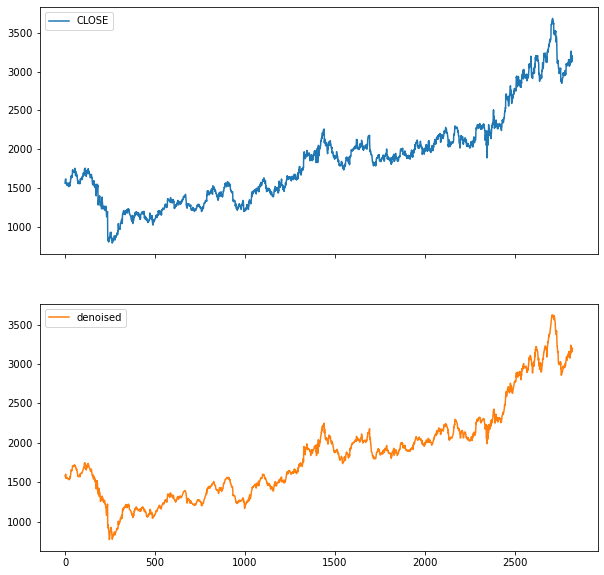

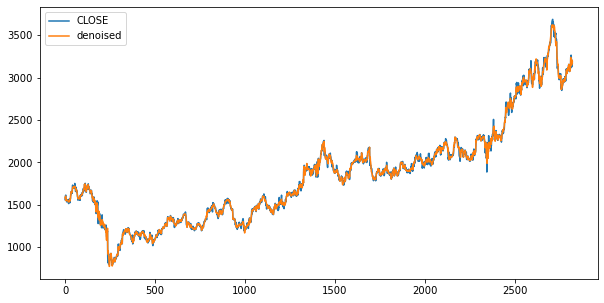

In [25]:
## Wavelet Transformation
coeff = WT(test_C, plot=True)

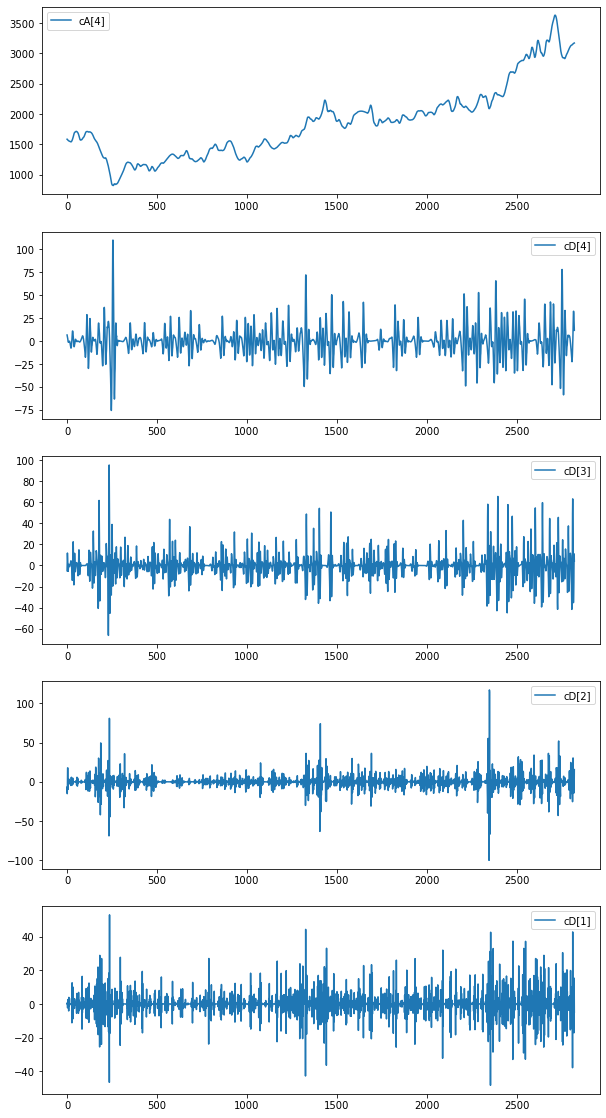

In [26]:
fig, ax =  plt.subplots(len(coeff), 1, figsize=(10, 20))
for i in range(len(coeff)):
    if i == 0:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(len(coeff)-i-1))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(len(coeff)-i))
        ax[i].legend(loc = 'best')

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

In [31]:
## ARMA Model
for i in range(1, len(coeff)):
    dftest = adfuller(coeff[i], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' % key] = value
    print((pd.DataFrame(dfoutput, columns=['cD[%.0f]'%(len(coeff)-i)])))
    print('\n')

                                  cD[4]
Test Statistic                -3.516765
p-value                        0.007567
#Lags Used                    14.000000
Number of observations Used  135.000000
Critical value(1%)            -3.479743
Critical value(5%)            -2.883198
Critical value(10%)           -2.578320


                                  cD[3]
Test Statistic                -5.596025
p-value                        0.000001
#Lags Used                    14.000000
Number of observations Used  135.000000
Critical value(1%)            -3.479743
Critical value(5%)            -2.883198
Critical value(10%)           -2.578320


                                    cD[2]
Test Statistic              -5.859418e+00
p-value                      3.438377e-07
#Lags Used                   1.400000e+01
Number of observations Used  1.350000e+02
Critical value(1%)          -3.479743e+00
Critical value(5%)          -2.883198e+00
Critical value(10%)         -2.578320e+00


                  

In [32]:
results = AR_MA(coeff)

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44814D+00    |proj g|=  1.07609D-01

At iterate    5    f=  1.44335D+00    |proj g|=  9.60201D-03

At iterate   10    f=  1.44177D+00    |proj g|=  9.28930D-03

At iterate   15    f=  1.44001D+00    |proj g|=  2.49072D-03

At iterate   20    f=  1.43992D+00    |proj g|=  2.51448D-03

At iterate   25    f=  1.43991D+00    |proj g|=  1.20601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    113      3     0     0   


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12170D+00    |proj g|=  7.65975D-02

At iterate    5    f=  2.08713D+00    |proj g|=  2.14352D-02

At iterate   10    f=  2.07742D+00    |proj g|=  3.87228D-02

At iterate   15    f=  2.07689D+00    |proj g|=  4.87321D-03

At iterate   20    f=  2.07609D+00    |proj g|=  5.23936D-04

At iterate   25    f=  2.07605D+00    |proj g|=  3.47367D-04

At iterate   30    f=  2.07605D+00    |proj g|=  4.66649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.87711D+00    |proj g|=  1.01474D-05

At iterate   45    f=  1.87711D+00    |proj g|=  7.23865D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    115      2     1     0   1.057D-05   1.877D+00
  F =   1.8771145180147562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20124D+00    |proj g|=  8.52234D-03

At iterate    5    f=  2.20119D+00    |proj g|=  1.83262D-03

At iter

 This problem is unconstrained.


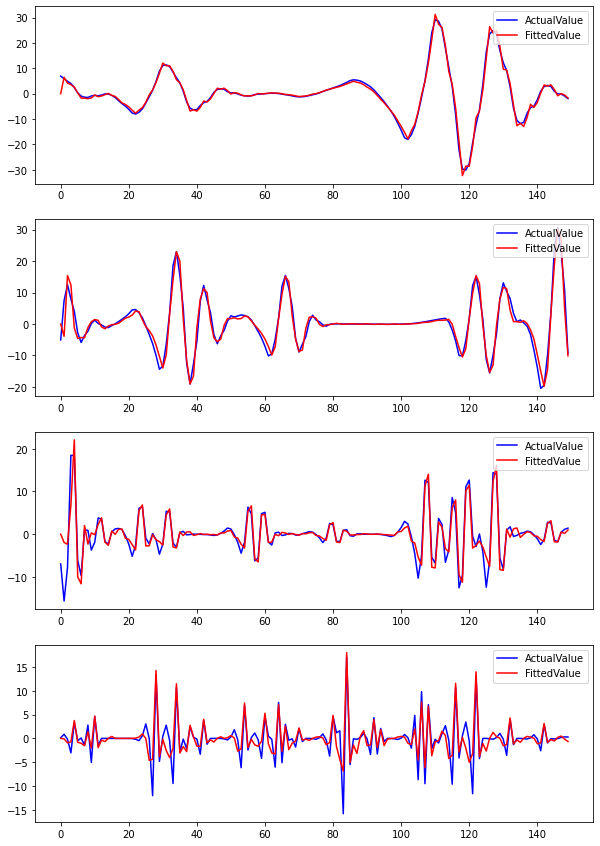

In [33]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coeff[i+1], 'blue', label='ActualValue')
    plt.legend(loc='upper right')
    plt.plot(results[i].fittedvalues, 'red', label='FittedValue')
    plt.legend(loc='upper right')

In [34]:
# ARMA_GBR
# Use the former 4 days' close price to predict the next day's close price. Using 150-day rolling windown to make prediction. Finally, try to make a prediction of 30-day close price.
features = 4 # this number is derived from the paper "The stock price based on the ARIMA_SVM combination model _ cheng changpin.(Chinese)". Since the prediction is the best when using 4 days close price to predict
forward =30
window = 150 # the rolling window should be as large as possible. Better larger than 100, since the time series ARMA model can't get inverted matrics if the time series is too short 
length = 1
index_predict, index_real = [], []
for i in range(forward):
    test_window = test_C[i:i+window]
    coeff = WT(test_window, lv=4, n=4)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, regressor='GBR', length=length, features = features)[-1:]
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window, window+length-1, dynamic=True))
    index_predict.append(Y_)
    index_real.append(test_C[i+window:i+window+length].values)

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44814D+00    |proj g|=  1.07609D-01

At iterate    5    f=  1.44335D+00    |proj g|=  9.60201D-03

At iterate   10    f=  1.44177D+00    |proj g|=  9.28930D-03

At iterate   15    f=  1.44001D+00    |proj g|=  2.49072D-03

At iterate   20    f=  1.43992D+00    |proj g|=  2.51448D-03

At iterate   25    f=  1.43991D+00    |proj g|=  1.20601D-03



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    113      3     0     0   8.836D-04   1.440D+00
  F =   1.4399127580106701     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12170D+00    |proj g|=  7.65975D-02

At iterate    5    f=  2.08713D+00    |proj g|=  2.14352D-02

At iterate   10    f=  2.07742D+00    |proj g|=  3.87228D-02

At iterate   15    f=  2.07689D+00    |proj g|=  4.87321D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f=  2.07605D+00    |proj g|=  4.66649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     52      1     0     0   4.666D-04   2.076D+00
  F =   2.0760513676056700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89648D+00    |proj g|=  8.00362D-02

At iterate    5    f=  1.88424D+00    |proj g|=  2.30553D-02

At iterate   10    f=  1.87756D+00    |proj g|=  1.34897D-03

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.87711D+00    |proj g|=  1.01474D-05

At iterate   45    f=  1.87711D+00    |proj g|=  7.23865D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    115      2     1     0   1.057D-05   1.877D+00
  F =   1.8771145180147562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20124D+00    |proj g|=  8.52234D-03

At iterate    5    f=  2.20119D+00    |proj g|=  1.83262D-03

At iter

 This problem is unconstrained.


ValueError: Expected 2D array, got 1D array instead:
array=[1646.7454 1642.3225 1637.7893 1633.1443].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict, 'red', label='PredictValue')
plt.legend(loc='best')
plt.plot(np.array(index_real)[:,0], 'blue', label='ActualValue') 
plt.legend(loc='best')

In [6]:
# # use groupby to get the average price of each stock on each month
# df_stock_month = df_stock.groupby(['ticker','month','year'])['Close'].mean().reset_index()
# df_stock_month

In [41]:
# sentiment_analysis_df_with_price and df_stock merge, but with the datetme
# sentiment_analysis_df_with_price change the "date" from datetime to string
# df_stock change the "date" from string to datetime
columns = ['company_name', 'Group', 'ticker', 'file_name', 'date', 'WA_sentiment'] 
company_df = sentiment_analysis_df_with_price[columns]
company_df['date'] = pd.to_datetime(company_df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])
# merge the two dataframe on=["date","ticker"]
merge_df = pd.merge(company_df, df_stock, on=["date","ticker"], how='left')
sentiment_analysis_df_with_price = merge_df.copy()
sentiment_analysis_df_with_price


/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_2820/1000518473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df['date'] = pd.to_datetime(company_df['date'])


,company_name,Group,ticker,file_name,date,WA_sentiment,Open,High,Low,Close,...,D-2,D+2,D-3,D+3,D-5,D+5,D-10,D+10,D-15,D+15
0,Admiral Group,Motor/Personal,ADM.L,20110302_Admiral_Group_PLC-_Earnings_Call_2011...,2011-03-02,-0.020513,1703.000000,1729.000000,1643.000000,1655.000000,...,-0.020130,0.015106,-0.003612,-0.000604,-0.011350,-0.003021,-0.029326,-0.060423,-0.030463,-0.045317
1,Admiral Group,Motor/Personal,ADM.L,20110824_Admiral_Group_PLC-_Earnings_Call_2011...,2011-08-24,0.001994,1500.000000,1500.000000,1331.000000,1353.000000,...,-0.110454,-0.025868,-0.094983,-0.005913,-0.125969,0.011086,-0.031496,0.008130,-0.117417,-0.028825
2,Admiral Group,Motor/Personal,ADM.L,20111109_Admiral_Group_PLC-_Guidance_Call_2011...,2011-11-09,-0.012026,990.000000,990.000000,815.500000,887.500000,...,-0.247881,-0.053521,-0.251686,-0.061972,-0.234914,-0.098028,-0.276691,-0.025352,-0.275510,0.039437
3,Admiral Group,Motor/Personal,ADM.L,20111109_Admiral_Group_PLC-_Guidance_Call_2011...,2011-11-09,-0.000319,990.000000,990.000000,815.500000,887.500000,...,-0.247881,-0.053521,-0.251686,-0.061972,-0.234914,-0.098028,-0.276691,-0.025352,-0.275510,0.039437
4,Admiral Group,Motor/Personal,ADM.L,20120307_Admiral_Group_PLC-_Earnings_Call_2012...,2012-03-07,-0.031913,1121.000000,1180.000000,1092.208008,1144.000000,...,0.095785,0.012238,0.080264,0.022727,0.062210,0.036713,0.103182,0.020979,0.179990,0.014860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,INTACT FINANCIAL-,Other insurers,IFC.TO,20201104_INTACT_FINANCIAL-_Earnings_Call_2020-...,2020-11-04,0.002050,143.279999,148.130005,140.119995,147.750000,...,0.069258,-0.019425,0.073609,-0.060778,0.063179,-0.080203,0.031990,0.000203,0.026255,-0.019628
1810,INTACT FINANCIAL-,Other insurers,IFC.TO,20210210_INTACT_FINANCIAL-_Earnings_Call_2021-...,2021-02-10,-0.009964,147.850006,153.350006,147.669998,151.820007,...,0.041432,-0.016994,0.039294,-0.032275,0.050876,-0.041101,0.061678,-0.054802,0.054013,-0.033263
1811,INTACT FINANCIAL-,Other insurers,IFC.TO,20210512_INTACT_FINANCIAL-_Earnings_Call_2021-...,2021-05-12,-0.001660,165.990005,167.229996,160.660004,162.309998,...,-0.027909,-0.011521,-0.015945,-0.015218,-0.009157,-0.027663,-0.003744,0.002403,-0.002704,0.041341
1812,INTACT FINANCIAL-,Other insurers,IFC.TO,20210728_INTACT_FINANCIAL-_Earnings_Call_2021-...,2021-07-28,-0.005704,173.000000,173.000000,168.440002,169.880005,...,0.008669,0.000706,0.007592,-0.002826,0.000294,0.000530,0.001238,0.026725,-0.010427,0.036320


In [42]:
df_Global_Commercial = sentiment_analysis_df_with_price[sentiment_analysis_df_with_price['Group']=='Global Commercial']
# df_Global_Commercial['ticker'].unique()
df_Global_Commercial_ZURNSW = df_Global_Commercial[df_Global_Commercial['ticker']=='ZURN.SW']
df_Global_Commercial_ZURNSW

array(['ALV.DE', 'CS.PA', 'ZURN.SW', 'G.MI'], dtype=object)

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

topic_modelling_df = pd.read_csv('./main_df_output/topic_modelling_df.csv')
topic_modelling_df_without_token = pd.read_csv('./main_df_output/topic_modelling_df_without_token.csv')
sentiment_analysis_df = pd.read_csv("./main_df_output/sentiment_analysis_df.csv")

## Viz

In [169]:
# test = df_Global_Commercial_ZURNSW[['date','WA_sentiment']]
# # test['date'] to string
# test['date'] = test['date'].astype(str)
# start_date = test['date'].to_list()
# # add '2021-12-31' to the end of the list
# end_date = start_date.copy()
# end_date.append('2021-12-31')
# # remove the end_date of first value from the list
# end_date.pop(0)
# # make ['WA_sentiment','start_date','end_date'] into a dataframe
# test = test.drop(columns=['date'])
# test['start_date'] = start_date
# test['end_date'] = end_date
# test
# # normalized the WA_sentiment between 0 to 9
# interval_min = test['WA_sentiment'].min()
# interval_max = test['WA_sentiment'].max()
# test['WA_sentiment_normalized'] = ((test['WA_sentiment'] - interval_min) / (interval_max - interval_min))*9
# # test sort by WA_sentiment
# test.sort_values(by=['start_date'], inplace=True)
# # reset the index
# test.reset_index(drop=True, inplace=True)
# # test

In [168]:
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots
# import yfinance as yf
# from decimal import Decimal

# df = yf.download("ZURN.SW", start=test['start_date'].loc[0], end="2021-12-31")

# fig = go.Figure(go.Candlestick(x=df.index,
#   open=df['Open'],
#   high=df['High'],
#   low=df['Low'],
#   close=df['Close']))
# # hide weekends
# fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])

# # add moving averages to df
# df['MA30'] = df['Close'].rolling(window=30).mean()
# df['MA15'] = df['Close'].rolling(window=15).mean()
# df['MA5'] = df['Close'].rolling(window=5).mean()

# fig.add_trace(go.Scatter(x=df.index, 
#                          y=df['MA5'], 
#                          opacity=0.7, 
#                          line=dict(color='blue', width=1), 
#                          name='MA 5'))
# fig.add_trace(go.Scatter(x=df.index, 
#                          y=df['MA15'], 
#                          opacity=0.7, 
#                          line=dict(color='purple', width=1), 
#                          name='MA 15'))
# fig.add_trace(go.Scatter(x=df.index, 
#                          y=df['MA30'], 
#                          opacity=0.7, 
#                          line=dict(color='black', width=1), 
#                          name='MA 15'))
# # removing all empty dates
# # build complete timeline from start date to end date
# dt_all = pd.date_range(start=df.index[0],end=df.index[-1])
# # retrieve the dates that ARE in the original datset
# dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df.index)]
# # define dates with missing values
# dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]
# fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
# fig.update_layout(
#   height=700,
#   width=1000,
#   title_text="ZURN.SW",
#   xaxis2=dict(rangeslider=dict(visible=False))
#    )
# for i in range(len(test)):
#     fig.add_shape(
#         type="rect",
#         x0=test.iloc[i]['start_date'],
#         y0=0,
#         x1=test.iloc[i]['end_date'],
#         y1=500,
#         # make the fillcolor to be continuous as the range of test.iloc[i]['WA_sentiment_normalized']
#         fillcolor=px.colors.sequential.Viridis[
#             int(test.iloc[i]['WA_sentiment_normalized'])
#         ],
#         line_width=0,
#         opacity=0.35
#     )

# # fig make annotation
# for i in range(len(test)):
#     fig.add_annotation(
#         x=test.iloc[i]['start_date'],
#         y=500,
#         # text = test.iloc[i]['WA_sentiment'] round with 4 decimal places
#         text=round(test.iloc[i]['WA_sentiment'],4),
#         showarrow=True,
#         arrowhead=7,
#         ax=0,
#         ay=-10,
#         # change the size of the text
#         font=dict(size=8)
#     )

# fig.show()

In [184]:
df

,Open,High,Low,Close,Adj Close,Volume,MA30,MA15,MA5
Date,,,,,,,,,
2014-05-15,259.799988,260.000000,257.299988,259.500000,164.829300,871573,NaN,NaN,NaN
2014-05-16,259.799988,262.899994,259.500000,262.899994,166.988907,950216,NaN,NaN,NaN
2014-05-19,261.799988,264.799988,261.799988,263.700012,167.497070,707632,NaN,NaN,NaN
2014-05-20,263.000000,265.700012,263.000000,264.299988,167.878143,688415,NaN,NaN,NaN
2014-05-21,265.000000,265.899994,263.299988,265.299988,168.513336,545913,NaN,NaN,263.139996
...,...,...,...,...,...,...,...,...,...
2021-12-23,395.000000,398.799988,394.799988,398.000000,378.662567,174205,391.416667,390.053335,392.940002
2021-12-27,397.700012,400.100006,397.299988,398.899994,379.518829,101521,391.313333,390.946667,394.360004
2021-12-28,400.000000,404.000000,399.100006,404.000000,384.371033,163352,391.366667,391.733333,397.720001


In [203]:
def stock_sentiment_plot(df,ticker):
    test = df.copy()
    # test['date'] to string
    test['date'] = test['date'].astype(str)
    start_date = test['date'].to_list()
    # add '2021-12-31' to the end of the list
    end_date = start_date.copy()
    end_date.append('2021-12-31')
    # remove the end_date of first value from the list
    end_date.pop(0)
    # make ['WA_sentiment','start_date','end_date'] into a dataframe
    test = test.drop(columns=['date'])
    test['start_date'] = start_date
    test['end_date'] = end_date
    test
    # normalized the WA_sentiment between 0 to 9
    interval_min = test['WA_sentiment'].min()
    interval_max = test['WA_sentiment'].max()
    test['WA_sentiment_normalized'] = ((test['WA_sentiment'] - interval_min) / (interval_max - interval_min))*9
    # test sort by WA_sentiment
    test.sort_values(by=['start_date'], inplace=True)
    # reset the index
    test.reset_index(drop=True, inplace=True)
    # test

    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import yfinance as yf
    from decimal import Decimal

    df = yf.download(ticker, start=test['start_date'].loc[0], end="2021-12-31")

    fig = go.Figure(go.Candlestick(x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']))
    # hide weekends
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])

    # add moving averages to df
    df['MA30'] = df['Close'].rolling(window=30).mean()
    df['MA15'] = df['Close'].rolling(window=15).mean()
    df['MA5'] = df['Close'].rolling(window=5).mean()

    fig.add_trace(go.Scatter(x=df.index, 
                            y=df['MA5'], 
                            opacity=0.7, 
                            line=dict(color='blue', width=1), 
                            name='MA 5'))
    fig.add_trace(go.Scatter(x=df.index, 
                            y=df['MA15'], 
                            opacity=0.7, 
                            line=dict(color='purple', width=1), 
                            name='MA 15'))
    fig.add_trace(go.Scatter(x=df.index, 
                            y=df['MA30'], 
                            opacity=0.7, 
                            line=dict(color='black', width=1), 
                            name='MA 30'))
    # removing all empty dates
    # build complete timeline from start date to end date
    dt_all = pd.date_range(start=df.index[0],end=df.index[-1])
    # retrieve the dates that ARE in the original datset
    dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df.index)]
    # define dates with missing values
    dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]
    fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
    fig.update_layout(
    height=700,
    width=1000,
    title_text=ticker,
    xaxis2=dict(rangeslider=dict(visible=False))
    )
    for i in range(len(test)):
        fig.add_shape(
            type="rect",
            x0=test.iloc[i]['start_date'],
            y0=min(df['Close']-20),
            x1=test.iloc[i]['end_date'],
            y1=max(df['Close']+20),
            # make the fillcolor to be continuous as the range of test.iloc[i]['WA_sentiment_normalized']
            fillcolor=px.colors.sequential.Viridis[
                int(test.iloc[i]['WA_sentiment_normalized'])
            ],
            line_width=0,
            opacity=0.35
        )

    # fig make annotation
    for i in range(len(test)):
        fig.add_annotation(
            x=test.iloc[i]['start_date'],
            y=max(df['Close']+20),
            # text = test.iloc[i]['WA_sentiment'] round with 4 decimal places
            text=round(test.iloc[i]['WA_sentiment'],4),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-10,
            # change the size of the text
            font=dict(size=8)
        )

    fig.show()

In [208]:
stock_sentiment_plot(df_Global_Commercial_ZURNSW[['date','WA_sentiment']], 'ZURN.SW')

[*********************100%***********************]  1 of 1 completed


In [211]:
df_Other_insurers = sentiment_analysis_df_with_price[sentiment_analysis_df_with_price['Group']=='Other insurers']
# df_Global_Commercial['ticker'].unique()
df_Other_insurers_TRYGCO = df_Other_insurers[df_Other_insurers['ticker']=='TRYG.CO']
stock_sentiment_plot(df_Other_insurers_TRYGCO[['date','WA_sentiment']],'TRYG.CO')

[*********************100%***********************]  1 of 1 completed


In [212]:
df_Other_insurers = sentiment_analysis_df_with_price[sentiment_analysis_df_with_price['Group']=='Other insurers']
# df_Global_Commercial['ticker'].unique()
df_Other_insurers_TOPCO = df_Other_insurers[df_Other_insurers['ticker']=='TOP.CO']
stock_sentiment_plot(df_Other_insurers_TOPCO[['date','WA_sentiment']],'TOP.CO')

[*********************100%***********************]  1 of 1 completed


In [213]:
df_Other_insurers = sentiment_analysis_df_with_price[sentiment_analysis_df_with_price['Group']=='Other insurers']
# df_Global_Commercial['ticker'].unique()
df_Other_insurers_0RHSIL = df_Other_insurers[df_Other_insurers['ticker']=='0RHS.IL']
stock_sentiment_plot(df_Other_insurers_0RHSIL[['date','WA_sentiment']],'0RHS.IL')

[*********************100%***********************]  1 of 1 completed


In [253]:
tp_TRYG = topic_modelling_df_without_token[topic_modelling_df_without_token['company_name']=='Tryg A-S-']
# tp_TRYG['date'] limit from 2015-05-01 to 2015-07-31
tp_TRYG_2015 = tp_TRYG[(tp_TRYG['date']>='2015-03-01') & (tp_TRYG['date']<='2015-05-31')]
tp_TRYG_2015.reset_index(drop=True, inplace=True)
tp_TRYG_2015['date'] = pd.to_datetime(tp_TRYG_2015['date'])
tp_TRYG_2015

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_2820/167666656.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,...,topic_82,topic_83,topic_84,topic_85,topic_86,topic_87,topic_88,topic_89,topic_90,topic_91
0,Jakob Brink,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,189.0,0.0,1.0,Tryg A-S-,Yeah. It's Jakob from ABG. I have two question...,Yeah It's from ABG I have two questions pleas...,question one premium growth competition premiu...,...,0.000673,0.000863,0.001254,0.001879,0.001182,0.000952,0.119374,0.080663,0.002457,0.001764
1,Lars Møller,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,3.0,1.0,0.0,Tryg A-S-,"Good morning, everyone. This is Lars Møller fr...",Good morning everyone This is from I'm the ...,morning q result today introduction,...,0.002293,0.002942,0.004277,0.006408,0.004031,0.003246,0.005399,0.007282,0.008379,0.006015
2,Morten Hübbe,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,8.0,1.0,0.0,Tryg A-S-,"Thank you, Lars. And we kick oﬀ on slide 3 whe...",Thank you And we kick oﬀ on slide where we s...,slide bag result q side increase result bit % ...,...,0.000083,0.000107,0.000155,0.005100,0.000147,0.029319,0.000196,0.000265,0.000305,0.000219
3,Morten Hübbe,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,171.0,1.0,0.0,Tryg A-S-,"Thank you, Tor. And we'll end our presentation...",Thank you And we'll end our presentation on s...,presentation slide target return equity - tax ...,...,0.000512,0.000657,0.000954,0.001430,0.000900,0.000724,0.001205,0.001625,0.001870,0.001342
4,Tor Magne Lønnum,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,90.0,1.0,0.0,Tryg A-S-,"Thank you, Morten. I guess ﬁrst and foremost, ...",Thank you I guess ﬁrst and foremost if you lo...,slide number slide number result trend term de...,...,0.000088,0.000112,0.000163,0.000245,0.000154,0.000124,0.000206,0.000278,0.000320,0.000230
5,Tor Magne Lønnum,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,202.0,1.0,0.0,Tryg A-S-,"Yes, Jakob. First and foremost, in terms of th...",Yes First and foremost in terms of the last q...,term question doubt sort variation term debt d...,...,0.000927,0.001190,0.001730,0.002591,0.001630,0.001313,0.002184,0.002945,0.003388,0.002433
6,Tor Magne Lønnum,20150415_Tryg_A-S-_Earnings_Call_2015-4-15_FS0...,2015-04-15,214.0,1.0,0.0,Tryg A-S-,I'm not prepared to say how aggressive we will...,I'm not prepared to say how aggressive we will...,term debt announcement presentation q et q tim...,...,0.001107,0.066067,0.002065,0.003094,0.001946,0.001567,0.002607,0.132808,0.004045,0.002904


In [254]:
# select the highest value amoung tp_TRYG_2015.iloc[:,16:109]
tp_TRYG_2015.iloc[:,16:109].max(axis=0).to_frame().reset_index().sort_values(by=0, ascending=False).head(10)

,index,0
21,topic_22,0.546809
12,topic_13,0.368518
55,topic_56,0.328377
69,topic_70,0.311564
33,topic_34,0.267572
47,topic_48,0.261500
74,topic_75,0.241084
65,topic_66,0.209894
8,topic_9,0.165299
20,topic_21,0.159263


In [258]:
# tp_TRYG_2015 get the highest score for topic_22
print(tp_TRYG_2015[tp_TRYG_2015['topic_22']==tp_TRYG_2015['topic_22'].max(axis=0)]['paraghrph'])

1    Good morning, everyone. This is Lars Møller fr...
Name: paraghrph, dtype: object
